# Convolutional Neural Network Demo

In this demo, we will be working to classify handwritten digits using the MNIST data set.  To accomplish this, we will be leveraging a Convolutional Neural Network (CNN).  

We will be using the [Keras](https://keras.io/) module on top of [TensorFlow](https://www.tensorflow.org/).

## MNIST Data Set

The MNIST database of handwritten digits is a common data set that is used when learning to solve the classification problem with neural networks. Keras includes this dataset, which enables it to be included into our project easily.

* [MNIST Data Set](http://yann.lecun.com/exdb/mnist/)
* [Keras MNIST Documentation](https://keras.io/datasets/#mnist-database-of-handwritten-digits)

In [1]:
# Import the module and the mnist dataset
import keras
from keras.datasets import mnist
# Import classes that we will need when creating the CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import to_categorical
# Import common Python libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import random

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nbuser/anaconda3_420/lib/pyth

After we have imported the needed modules, we will be importing the actual MNIST data.  Keras makes this very easy.  When we load the data, we'll have the test and training images (represented by `training_images` and `test_images` respectively) as well as the labels (repesented by `training_labels` and `test_labels` respectively).

In [5]:
# Load in the data for the MNIST data set into its training and test data buckets
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
print('Training Images Shape: {0}'.format(training_images.shape))
print('Training Labels Shape: {0}'.format(len(training_labels)))
print('Test Images Shape: {0}'.format(test_images.shape))
print('Test Labels Shape: {0}'.format(len(test_labels)))

11476992/11490434 [============================>.] - ETA: 0sTraining Images Shape: (60000, 28, 28)
Training Labels Shape: 60000
Test Images Shape: (10000, 28, 28)
Test Labels Shape: 10000


We will add in a utility function to help us get a sampling of the test data within the MNIST data set.

In [6]:
# This function gets us a specific number of images for each of the labels (classes)
def find_sample_data(images, image_labels, max_num_per_class, randomize=False, sort=False, classes=None):
    if classes is None:
        classes = np.unique(image_labels)
    output = []
    for i in classes:
        index_positions = np.where(image_labels == i)
        indexes = index_positions[0][:max_num_per_class]
        for index in indexes:
            output.append((images[index], image_labels[index]))
    if randomize:
        random.shuffle(output)
    if sort:
        output.sort(key=lambda tup: tup[1])
    return output    

Now that we have a method to get some data from the test data set, let's get a sampling of the data provided across all classes in the data set:

In [9]:
# Get 4 items of each class in the data set.  This should allow us to see representations of all digits
extracted_test_data = find_sample_data(test_images, test_labels, 4, randomize=True)
print('Sample Data Length: {0}'.format(len(extracted_test_data)))

Sample Data Length: 40


Next, we will add in a utility function to help us visualize the sample data that we extracted in the previous cell:

In [11]:
def plot_images(image_data):
    cols = min(8, len(image_data))
    rows = math.ceil(len(image_data)/cols)
    fig, ax = plt.subplots(rows, cols, figsize=(18,(2.5 * rows)))
    for i in range(cols*rows):
        col = i % cols
        row = i // cols
        if rows > 1:
            axis = ax[row, col]
        elif cols == 1:
            axis = ax
        else:
            axis = ax[col]
        if len(image_data) < (i + 1):
            axis.axis('off')
        else:
            data = image_data[i]
            axis.imshow(data[0], cmap='gray_r')
            axis.axis('on')
            axis.get_xaxis().set_ticks([])
            axis.get_yaxis().set_ticks([])
            if len(data) == 2:
                axis.set_title('Number: {0}.'.format(data[1]))
    plt.subplots_adjust(hspace=0.5)
    plt.show()

With this function now in place, we can now visualize the data that we extracted:

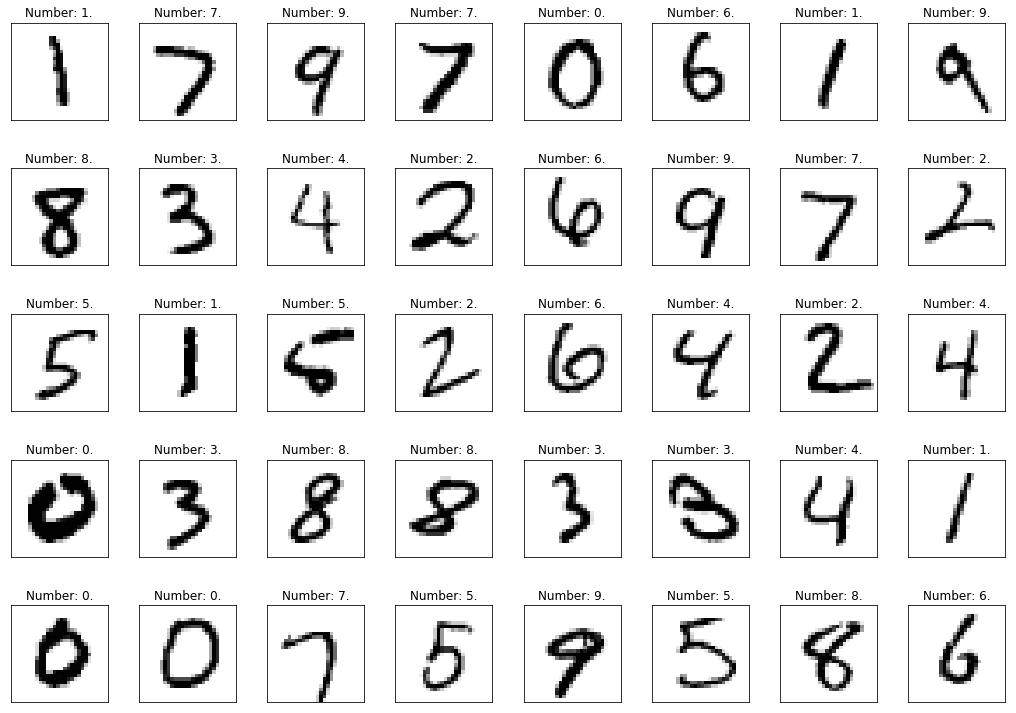

In [12]:
# Visualize the images we extracted in a previous cell
plot_images(extracted_test_data)

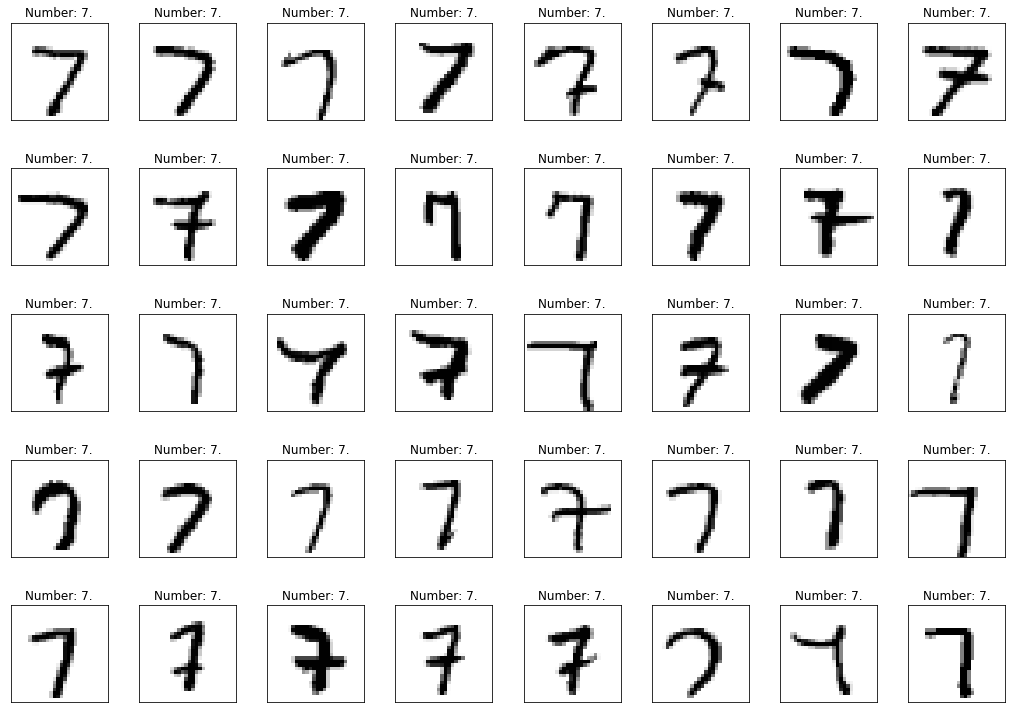

In [13]:
# Get 40 examples of the number 7
single_digit_data = find_sample_data(test_images, test_labels, 40, classes=[7])
plot_images(single_digit_data)

If we focus on a single digit, we can begin to see the difficulty that would arise in trying to use a non-learning based approach to classify the digits:

This classification challenge is perfectly suited for a Convolutional Neural Network. We will setup one in the following section of this notebook.

## Convolutional Neural Network Setup

Now that we have our data set in place, we will move forward with the classification task. First, we will preprocess the data, then we will create our CNN.  Finally, we will use our compiled model to run predictions for some of the images from the data set.

### Preprocessing

In this step, we will perform a few steps to prepare the data for use within our CNN.  The first step is to create a new array with each element cast as a `float32`.  Next, we need to normalize the data between 0 and 1.

In [16]:
def preprocess_image_data(image_data):
    new_image_data = image_data
    # Reshape the data to what keras is expecting
    new_image_data = new_image_data.reshape(new_image_data.shape[0], new_image_data.shape[1], new_image_data.shape[2], 1)
    # Create a new array with its elements cast as float32
    new_image_data = new_image_data.astype('float32')
    # Change image values to 0..1 instead of 0..255
    new_image_data = new_image_data / 255
    return new_image_data

# Preprocess Training Image Data
print('First image in the set: {0}'.format(training_images[0]))
preprocessed_training_images = preprocess_image_data(training_images)
print('First transformed image in the set: {0}'.format(preprocessed_training_images[0]))
# Preprocess Test Image Data
preprocessed_test_images = preprocess_image_data(test_images)

First image in the set: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 25

We also need to do some minimal preprocessing on the labels:

In [17]:
num_classes = 10

def preprocess_label_data(label_data):
    new_label_data = label_data
    # Utilize the Keras utility to setup categorization of labels
    new_label_data = to_categorical(new_label_data, num_classes)
    return new_label_data

# Preprocess Training Label Data
print('First label in the set: {}'.format(training_labels[0]))
preprocessed_training_labels = preprocess_label_data(training_labels)
print('First transformed label in the set: {}'.format(preprocessed_training_labels[0]))
# Preprocess Test Label Data
preprocessed_test_labels = preprocess_label_data(test_labels)

First label in the set: 5
First transformed label in the set: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Create the Convolutional Neural Network (CNN)

We will be creating a function that allows for us to pass in our defined network, data, and number of epochs for compilation and evaluation.

In [20]:
# Wrap the data in a single var
evaluation_data = preprocessed_training_images, preprocessed_training_labels, preprocessed_test_images, preprocessed_test_labels

# Create a function for compiling and evaluating the model against the data
def compile_evaluate_model(model, model_data, epochs, visualize=True):
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    history = model.fit(model_data[0], 
                        model_data[1],
                        batch_size=128,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(model_data[2], model_data[3]))

    score = model.evaluate(model_data[2], model_data[3], verbose=0)
    
    if visualize == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
        ax1.plot(history.history['acc'], color="#f05a28")
        ax1.plot(history.history['val_acc'], color="#2b9fbc")
        ax1.set(xlabel='Epoch', ylabel='Accuracy', title='Model Accuracy')
        ax1.legend(['Train', 'Test'], loc='upper left')
        ax2.plot(history.history['loss'], color="#f05a28")
        ax2.plot(history.history['val_loss'], color="#2b9fbc")
        ax2.set(xlabel='Epoch', ylabel='Loss', title='Model Loss')
        ax2.legend(['Train', 'Test'], loc='upper left')

    print('Test loss:{0}'.format(score[0]))
    print('Test accuracy:{0}'.format(score[1]))

Now that we have this function to evaluate the model, we can create the layers for our CNN. In this case, we will have a three layer CNN:

1. The first layer will be a 2D Convolutional layer with a `3x3` kernel and a `relu` activation function.
1. The next layer will be a max pooling layer with a `2x2` pool size.
1. Next, we will have a Dropout layer.
1. Next, we will have a flattening layer to convert the data to a 1D matrix.
1. Next, we will have a Dense (fully-connected) layer with 128 neurons and a `relu` activation function.
1. The final layer will be our full connected layer with 10 neurons (one for each class) with the expected `softmax` activation function (since we have a classification task with more than 2 options).

In [21]:
# Create and visualize our Convolutional Neural Network
input_shape = evaluation_data[0][0].shape

model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


Now that we have defined a model for our CNN, we can compile and evaluate the model.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 170s - loss: 0.3593 - acc: 0.8977 - val_loss: 0.1539 - val_acc: 0.9544
Epoch 2/10
60000/60000 [==============================] - 164s - loss: 0.1368 - acc: 0.9597 - val_loss: 0.0953 - val_acc: 0.9723
Epoch 3/10
60000/60000 [==============================] - 166s - loss: 0.0980 - acc: 0.9716 - val_loss: 0.0721 - val_acc: 0.9786
Epoch 4/10
60000/60000 [==============================] - 169s - loss: 0.0786 - acc: 0.9768 - val_loss: 0.0644 - val_acc: 0.9794
Epoch 5/10
60000/60000 [==============================] - 166s - loss: 0.0678 - acc: 0.9798 - val_loss: 0.0539 - val_acc: 0.9827
Epoch 6/10
60000/60000 [==============================] - 163s - loss: 0.0580 - acc: 0.9829 - val_loss: 0.0531 - val_acc: 0.9823
Epoch 7/10
60000/60000 [==============================] - 166s - loss: 0.0528 - acc: 0.9843 - val_loss: 0.0482 - val_acc: 0.9838
Epoch 8/10
60000/60000 [=======================

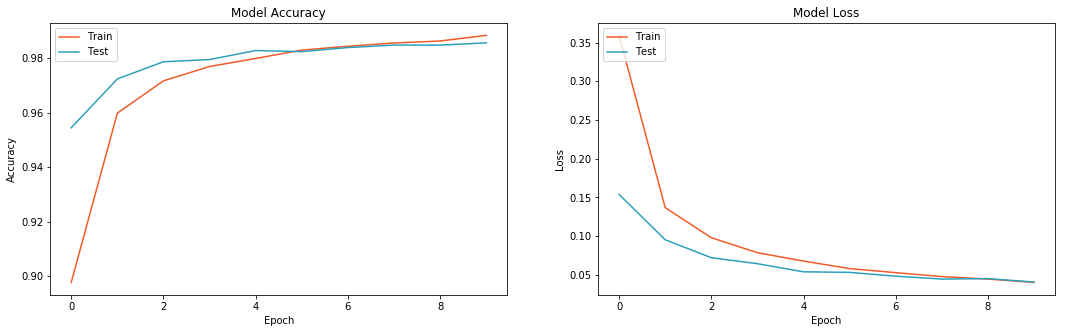

In [22]:
# Evaluate this model
compile_evaluate_model(model, evaluation_data, 10)

### Predictions

Now that we have a compiled model, we can now run predictions against the model.  We will create two functions: one that runs predictions against our model, and a second which allows for us to visualize the results.

In [23]:
# Get the Class Names
class_names = np.unique(training_labels)

# Provide the array of predictions for the passed in image
def predict_image(index, use_training=True):
    if use_training:
        image = preprocessed_training_images[index]
    else:
        image = preprocessed_test_images[index]
    image_test = (np.expand_dims(image,0))
    return model.predict(image_test)[0]

# Function to predict an image based on the model and visualize predictions
def visualize_image_prediction(index, use_training=True):
    if use_training:
        image = training_images[index]
    else:
        image = test_images[index]
    predictions = predict_image(index, use_training)
    fig = plt.figure(figsize=(18, 5))
    grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)
    plt.subplot(grid[0, 0])
    plt.imshow(image, cmap='gray_r')
    plt.subplot(grid[0, 1:])
    plt.bar(range(10), predictions, color="#f05a28")
    plt.xticks(range(10), class_names)

We can now run our prediction function against an image from the data set:

In [24]:
predict_image(0)

array([1.8919925e-10, 1.7099790e-08, 6.2318009e-08, 1.1731127e-02,
       1.4656832e-12, 9.8826808e-01, 4.0192460e-10, 1.4895917e-07,
       5.4055766e-07, 4.1872262e-08], dtype=float32)

Now we can visualize those results to see the predictions provided by our CNN:

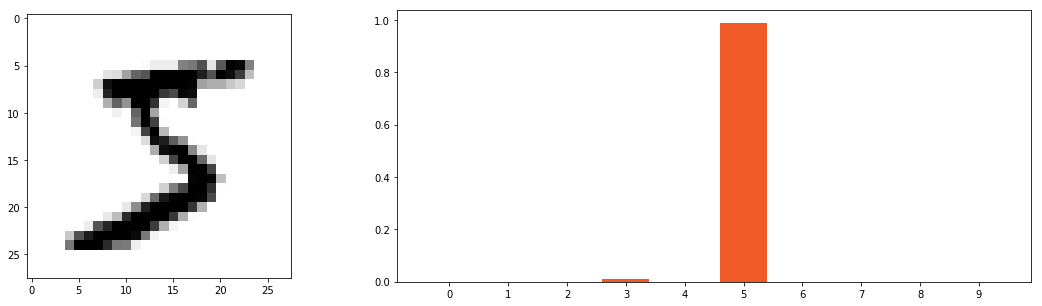

In [25]:
visualize_image_prediction(0)

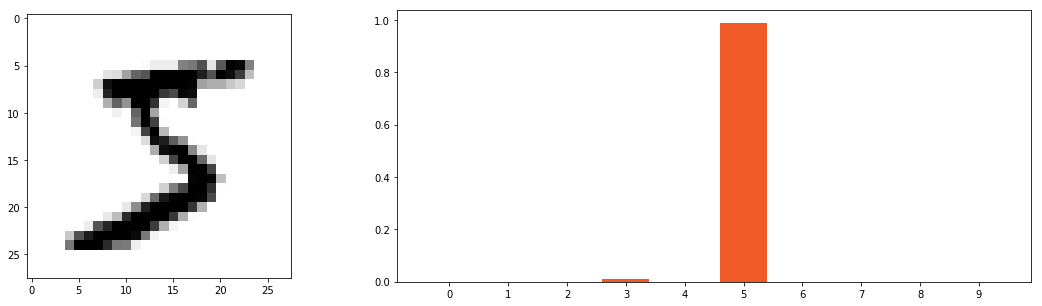

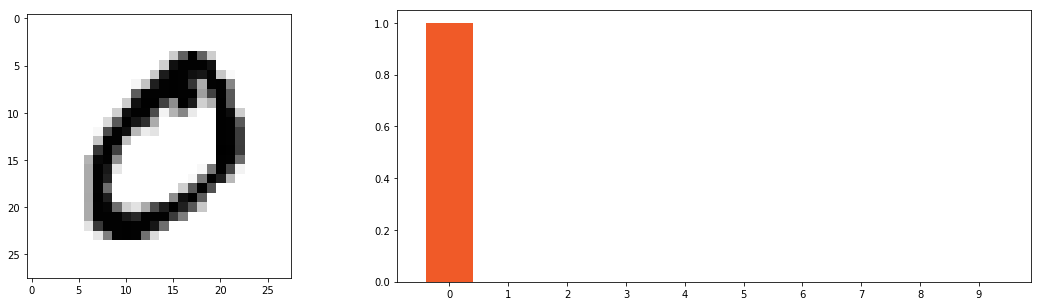

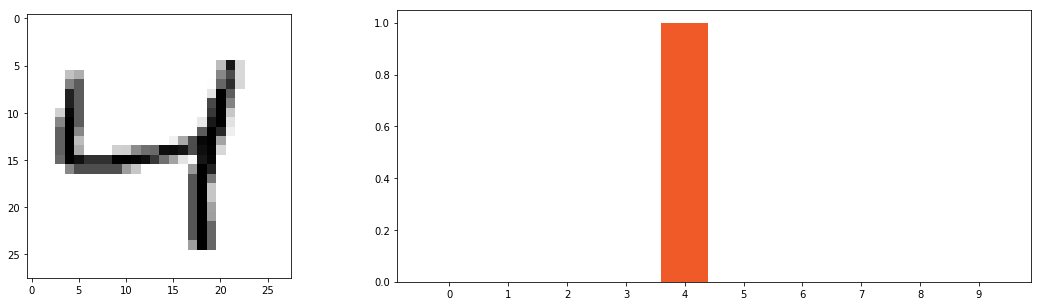

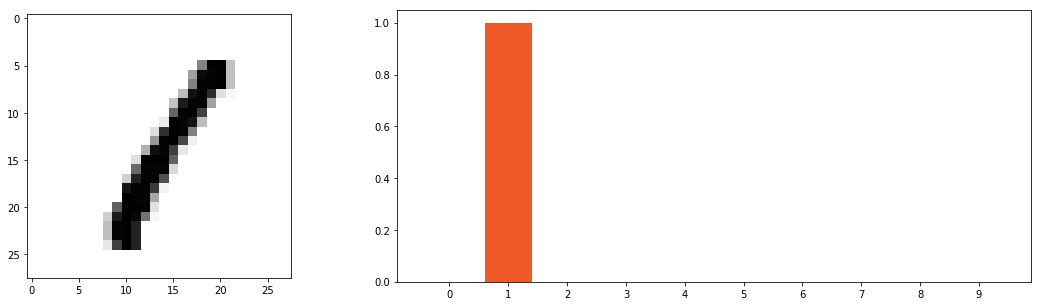

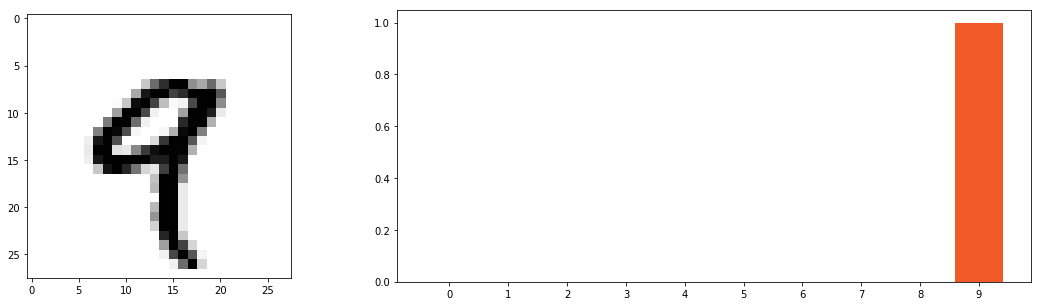

In [26]:
for i in range(5):
    visualize_image_prediction(i)

Since we now can determine a prediction for each image, we can run that against every image in our training data set.  If there are multiple predictions above a threshold (in this case `0.1`), then it is likely that these images are outliers.  

We can use this kind of information to further refine our model and work to increase accuracy.

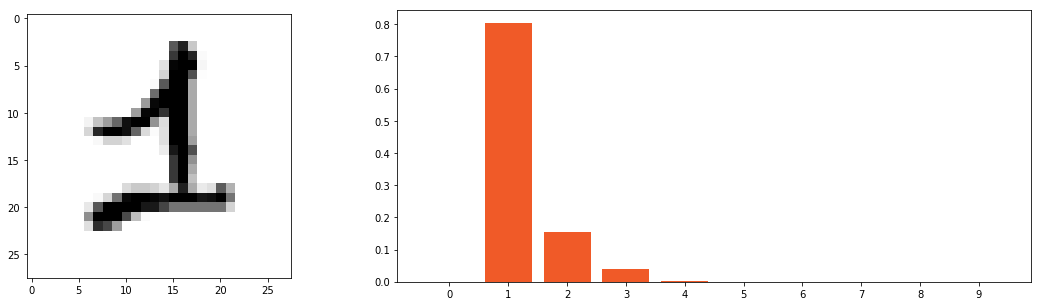

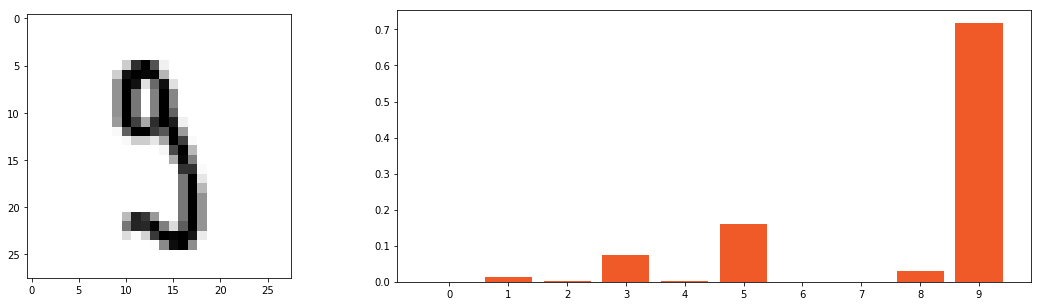

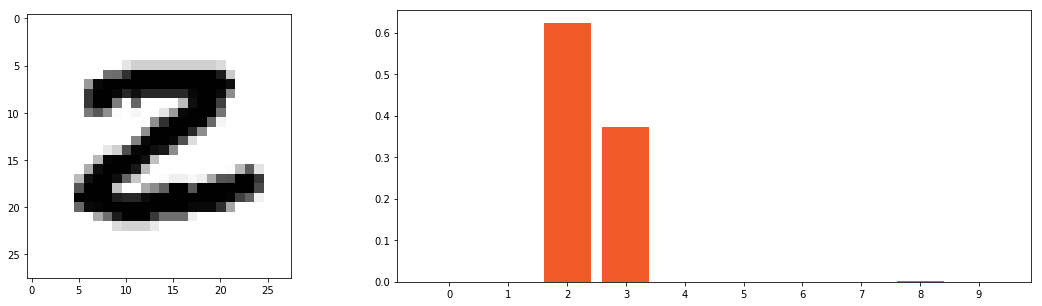

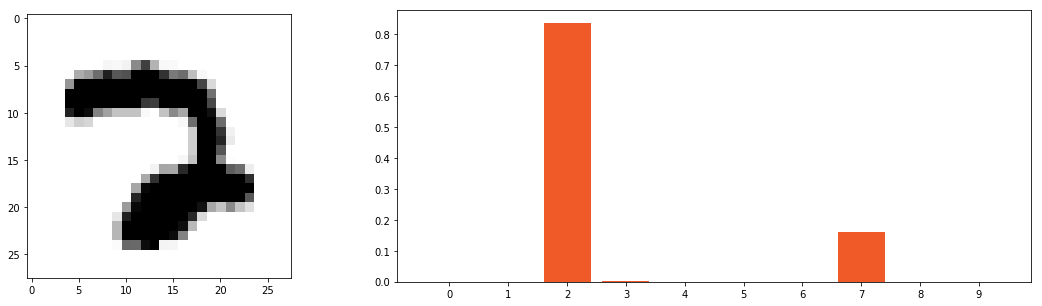

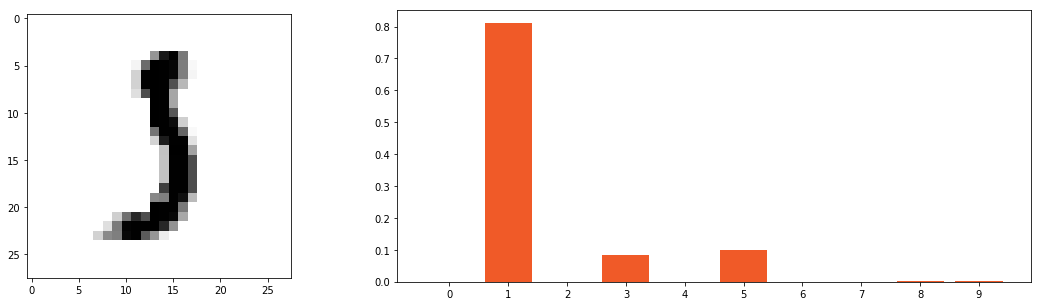

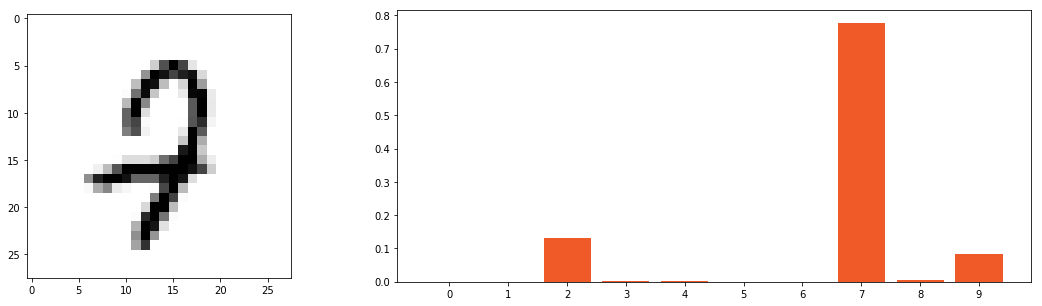

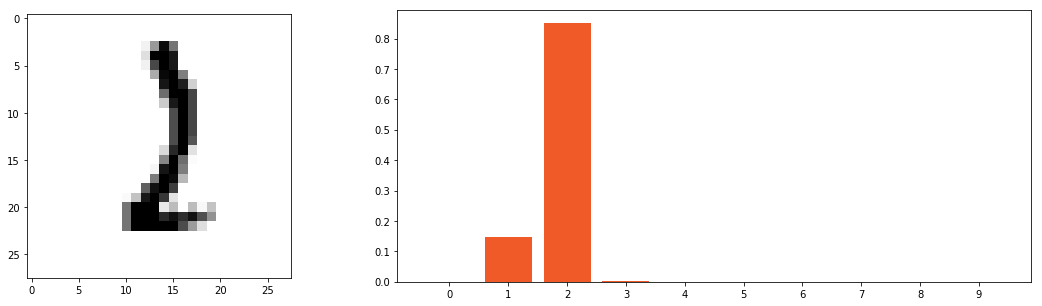

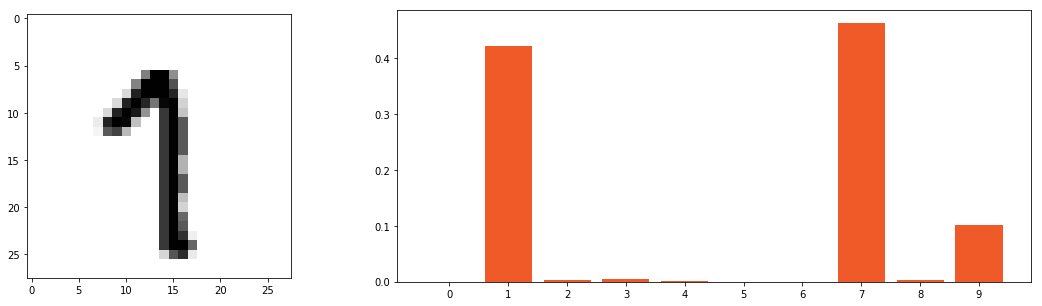

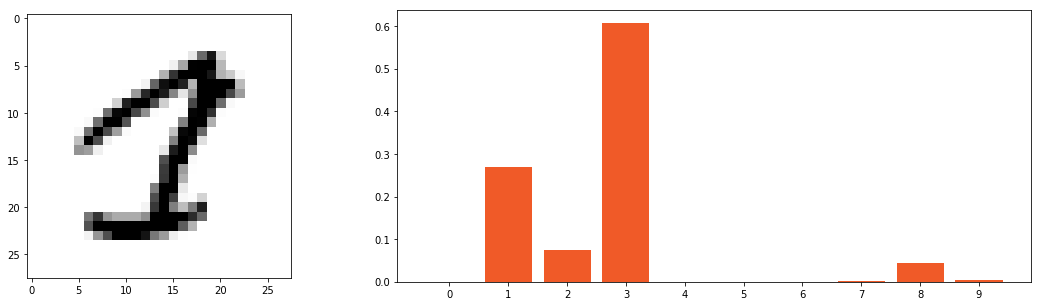

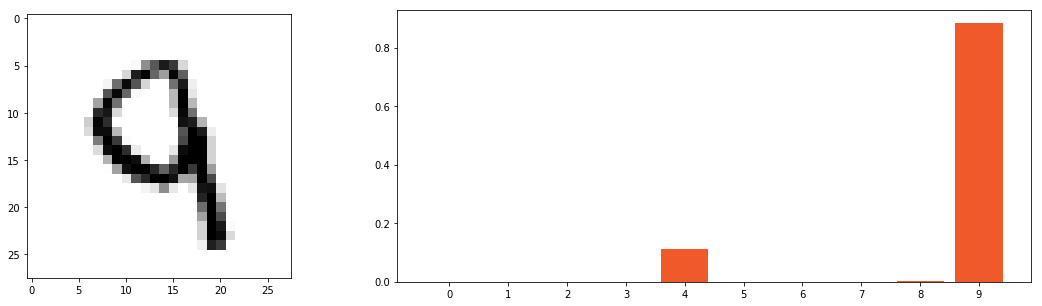

In [27]:
output = []
for i, image in enumerate(training_images):
    predictions = predict_image(i)
    filtered_predictions = [prediction for prediction in predictions if prediction > 0.1]
    if len(filtered_predictions) > 1:
        output.append(i)
        
for i in output[:10]:
    visualize_image_prediction(i)